In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import seaborn
import networkx as nx
import pandas as pd
from scipy.ndimage.filters import gaussian_filter1d
import scipy.stats as stt
import scipy as sp
import re
import matplotlib
sys.path.append(r'\Users\takam\Documents\Code\line_loop\packages')
sys.path.append(r"C:\Users\yweissenberger\Documents\code\line_loop-master")
sys.path.append(r"C:\Users\yweissenberger\Documents\code\line_loop-master\packages")
sys.path.append("/Users/yves/Documents/Code/line_loop/packages/")
clrs = seaborn.color_palette()

seaborn.set(font_scale=1.5,style='ticks')


import mouse_poker as mpk
from mouse_poker.ephys_load import *
#import yutils

poke_pos = [ [149,0],
         [68,19],[231,19],
       [0,62],[149,62],[298,62],
         [68,105],[231,105],
              [149,124]]
pos = np.array([1,-1])*poke_pos


/Users/yves/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
def make_plot(res_dict,mx=1,color='mean'):
    plt.figure(figsize=(12,4))


#    mx = 1
    if color=='pval': cmap_ = 'RdYlGn_r'
    else: cmap_ = 'RdYlGn'
    cmap = matplotlib.cm.ScalarMappable(matplotlib.colors.Normalize(vmin=0,vmax=mx,clip=True),cmap=cmap_)

    plt.subplot(1,2,1)
    G0 = nx.DiGraph()
    G0.add_nodes_from(range(9),pos=np.array([1,-1])*poke_pos,color='.3')
    nx.draw(G0,pos=pos,alpha=.2,node_color='.3')


    G = nx.DiGraph()
    for k,v in res_dict.items():
        if color=='pval':
            c = stt.binom_test(np.sum(v),len(v),p=1/9.)
        else:
            c= np.mean(v)
        G.add_edge(int(k[0]),int(k[1]),color=cmap.to_rgba(c))

    colors = nx.get_edge_attributes(G,'color')

    nx.draw(G,
            pos=pos,edge_color=np.array(list(colors.values())),
            node_color='.3',
            node_size=768,
            connectionstyle="arc3,rad=-0.1",
            width=3
    )


    plt.subplot(1,2,2)

    plt.imshow(np.array([[0,mx]]).T,aspect=1001,cmap=cmap_)
    plt.gca().set_visible(False)
    cax = plt.axes([.6, 0.025, 0.025, 0.8])
    cbar = plt.colorbar(cax=cax)
    cbar.ax.set_ylabel("Proportion correct \n(probe trials)")
    plt.tight_layout()


#G = nx.Graph()


In [3]:
def get_modulo_distance(rloc,state,nStates=6):
    """ Get modulo distance for distance of reward over circle. Assumes states are 0 indexed"""
    return np.min(np.abs([rloc-state,rloc-(state+nStates),rloc-(state-nStates)]))

In [4]:
get_modulo_distance(5,1)

2

In [79]:

def get_inpoke_data(lines):
    
    event_line = [l for ix,l in enumerate(lines) if l[0]=='E'][0]
    state_line = [l for ix,l in enumerate(lines) if l[0]=='S'][0]

    event_dict = eval(event_line[2:-1])
    state_dict = eval(state_line[2:-1])
    event_dict2 = {v: k for k, v in event_dict.items()}

    inPoke_evs = sorted([(k,v) for k,v in event_dict.items() if (re.findall(r'poke_[0-9]',k) and 'out' not in k)])
    inPoke_ids = [i[1] for i in inPoke_evs]
    
    
    inPokes = []
    inPoke_ts = []
    for l_ in lines:
        d_ = re.findall('D [0-9]* ([0-9]*)\n',l_)

        if d_:
            if int(d_[0]) in inPoke_ids:

                t = re.findall('D ([0-9]*) [0-9]*\n',l_)[0]
                inPoke_ts.append(float(t))
                inPokes.append(int(event_dict2[int(d_[0])][-1]))
    return np.array(inPokes), np.array(inPoke_ts)



    
def get_performance(state_seqs,lineloop='line',minNrew=0,n_till_guide=10,firstOnly=False):
    """ 
    Get fraction correct in each state 
    
    """
    perf = np.zeros([9,9])
    perf_ctr = np.zeros([9,9])
    rew_hist = []
    all_rew_loc = []
    for state_seq in state_seqs:
        #print('2')
        rew_loc = state_seq[-1]
        if not rew_hist:
            rew_hist.append(rew_loc)
        elif rew_loc==rew_hist[-1]:
            rew_hist.append(rew_loc)
        else:
            rew_hist = []

        has_visited= []
        if len(rew_hist)>minNrew:
            #print('0')
            for ix,state in enumerate(state_seq[:-1]):

                if ix<n_till_guide:
                    #print('1')
                    if lineloop=='loop':
                        d0 = get_modulo_distance(state,rew_loc)
                        d1 = get_modulo_distance(state_seq[ix+1],rew_loc)
                    elif lineloop=='line':
                        d0 = np.abs(state-rew_loc)
                        d1 = np.abs(state_seq[ix+1]-rew_loc)


                    if state not in has_visited:

                        if d1<d0:
                            perf[state,rew_loc] += 1
                            perf_ctr[state,rew_loc] += 1
                        else:
                            perf[state,rew_loc] += 0
                            perf_ctr[state,rew_loc] += 1
                            if firstOnly: has_visited.append(state)
    
    for i in np.unique(rew_hist):
        perf[i,i] = np.nan

    return perf, perf_ctr
    

In [80]:
def get_rews(lines):
    
    event_line = [l for ix,l in enumerate(lines) if l[0]=='E'][0]
    state_line = [l for ix,l in enumerate(lines) if l[0]=='S'][0]

    event_dict = eval(event_line[2:-1])
    state_dict = eval(state_line[2:-1])
    event_dict2 = {v: k for k, v in event_dict.items()}
    rew_state = state_dict['deliver_reward']
    rew_ts = []
    for l_ in lines:
        if (l_[0]=='D' and (l_[-3])==str(rew_state)):
            rew_ts.append(float(re.findall('D ([0-9]*)',l_)[0]))
            #rew_locs.append()
    return rew_ts

In [81]:
def get_lights_on_timers(lines):
    event_line = [l for ix,l in enumerate(lines) if l[0]=='E'][0]
    state_line = [l for ix,l in enumerate(lines) if l[0]=='S'][0]

    event_dict = eval(event_line[2:-1])
    state_dict = eval(state_line[2:-1])
    event_dict2 = {v: k for k, v in event_dict.items()}
    lot_state = str(event_dict['lights_on_timer'])
    lot_ts = []
    for l_ in lines:
        if (l_[0]=='D' and (l_[-3:-1])==str(lot_state)):
            lot_ts.append(float(re.findall('D ([0-9]*)',l_)[0]))
            #rew_locs.append()
    return np.array(lot_ts)

In [82]:
def get_rew_timers(lines):
    event_line = [l for ix,l in enumerate(lines) if l[0]=='E'][0]
    state_line = [l for ix,l in enumerate(lines) if l[0]=='S'][0]

    event_dict = eval(event_line[2:-1])
    state_dict = eval(state_line[2:-1])
    event_dict2 = {v: k for k, v in event_dict.items()}
    lot_state = str(event_dict['rew_timer'])
    lot_ts = []
    for l_ in lines:
        if (l_[0]=='D' and (l_[-3:-1])==str(lot_state)):
            lot_ts.append(float(re.findall('D ([0-9]*)',l_)[0]))
            #rew_locs.append()
    return np.array(lot_ts)

In [83]:
def get_transitions(state_seqs,minNrew=5,firstOnly=False,n_till_guide=10):
    """ This function obtains empirical counts for transitions from a given state to another
        as a function of """
    perf = np.zeros([9,9,9])
    perf_ctr = np.zeros([9,9,9])
    rew_hist = []
    transition_mtx = np.zeros([9,9,9])
    state_ctr = np.zeros([9,9])
    all_rew_loc = []
    for state_seq in state_seqs:
        #print('2')
        rew_loc = state_seq[-1]
        all_rew_loc.append(rew_loc)
        if not rew_hist:
            rew_hist.append(rew_loc)
        elif rew_loc==rew_hist[-1]:
            rew_hist.append(rew_loc)
        else:
            rew_hist = []
        has_visited= []
        if len(rew_hist)>minNrew:

            for ix,state in enumerate(state_seq[:-1]):
                if ix<n_till_guide:
                    #state = state_seq[pk_ctr]
                    if state not in has_visited:

                        next_state = state_seq[ix++1]

                        transition_mtx[state,next_state,rew_loc] += 1
                        state_ctr[state,rew_loc] += 1
                        if firstOnly: has_visited.append(state)


    return transition_mtx, state_ctr, np.unique(all_rew_loc)

In [110]:
lines

['I Experiment name  : homecage24_poke_seq\n',
 'I Task name : basic_rew_collect_navi_circle\n',
 'I Subject ID : 468631_2\n',
 'I Start date : 2021-04-23-043849\n',
 '\n',
 "S {'handle_poke': 1, 'reward_consumption': 2, 'deliver_reward': 3, 'change_task': 4, 'ITI': 5}\n",
 '\n',
 "E {'lights_on_timer': 30, 'poke_2_out': 9, 'poke_8_out': 21, 'iti_timer': 29, 'light_timer': 27, 'rew_timer': 26, 'poke_3_out': 11, 'poke_9': 22, 'poke_8': 20, 'poke_5_out': 15, 'poke_timer': 28, 'poke_3': 10, 'poke_2': 8, 'poke_1': 6, 'poke_4_out': 13, 'poke_6_out': 17, 'poke_7': 18, 'poke_6': 16, 'poke_1_out': 7, 'poke_5': 14, 'poke_4': 12, 'poke_7_out': 19, 'poke_9_out': 23, 'end_consumption': 24, 'session_timer': 25}\n",
 '\n',
 'D 0 1\n',
 'D 601 30\n',
 'D 2123 14\n',
 'D 2482 15\n',
 'D 2726 30\n',
 'D 3377 10\n',
 'D 3533 11\n',
 'D 3576 10\n',
 'D 3653 11\n',
 'D 3987 16\n',
 'D 4109 17\n',
 'D 4366 10\n',
 'D 4522 11\n',
 'D 4589 30\n',
 'D 4736 6\n',
 'D 4737 3\n',
 'P 4738 nREWS:0fracL:0.5\n',
 '

In [125]:

res_dict__ = {'a':[],
              'b':[],
              'c':[]}
all_perf = np.zeros([9,9])
all_perf_ctr = np.zeros([9,9])
all_a = np.zeros([9,9,9])
all_b = np.zeros([9,9])
all_c = []
for fn_ in fs[-6:-1]:
    f = open(os.path.join(fs_dir,fn_),'r')
    
    lines = f.readlines()
    all_state_seq = get_base_info(lines)
    a,b,c = get_transitions(state_seqs=all_state_seq)
    print(np.sum(a))
    res_dict__['a'].append(a)
    res_dict__['b'].append(b)
    res_dict__['c'].append(c)
    all_c.extend(c)
    print(c)
    all_a += a
    all_b += b
    #all_perf+= p_
    #all_perf_ctr += pctr
    #get_transitions(state_seqs=all_state_seq)

0.0
[2]
0.0
[3]


ValueError: attempt to get argmin of an empty sequence

In [132]:
lines

['I Experiment name  : homecage24_poke_seq\n',
 'I Task name : basic_rew_collect_navi_circle\n',
 'I Subject ID : 468631_2\n',
 'I Start date : 2021-04-23-055220\n',
 '\n',
 "S {'handle_poke': 1, 'reward_consumption': 2, 'deliver_reward': 3, 'change_task': 4, 'ITI': 5}\n",
 '\n',
 "E {'lights_on_timer': 30, 'poke_2_out': 9, 'poke_8_out': 21, 'iti_timer': 29, 'light_timer': 27, 'rew_timer': 26, 'poke_3_out': 11, 'poke_9': 22, 'poke_8': 20, 'poke_5_out': 15, 'poke_timer': 28, 'poke_3': 10, 'poke_2': 8, 'poke_1': 6, 'poke_4_out': 13, 'poke_6_out': 17, 'poke_7': 18, 'poke_6': 16, 'poke_1_out': 7, 'poke_5': 14, 'poke_4': 12, 'poke_7_out': 19, 'poke_9_out': 23, 'end_consumption': 24, 'session_timer': 25}\n",
 '\n',
 'D 0 1\n',
 'D 105 11\n',
 'D 565 22\n',
 'D 602 30\n',
 'D 777 23\n',
 'D 1040 18\n',
 'D 1099 19\n',
 'D 1327 14\n',
 'D 1662 15\n',
 'D 1695 14\n',
 'D 1831 15\n',
 'D 1929 30\n',
 'D 1955 14\n',
 'D 2123 15\n',
 'D 2342 18\n',
 'D 2481 19\n',
 'D 2707 22\n',
 'D 2854 23\n',
 

In [127]:
all_c = list(set(c))

In [129]:
  to_ret = np.array([(all_a/all_b[:,None])[:,:,i]
                           for i in range(9)])

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


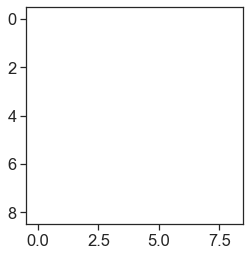

In [130]:
plt.imshow(to_ret[3])

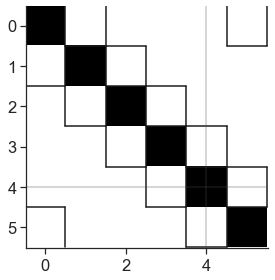

In [123]:
draw_transition_matrix(to_ret,4,used_states=np.arange(6),rew_indices=np.arange(6),lineloop='loop')

In [55]:
def draw_transition_matrix(transition_mtx,ix_,used_states,rew_indices,lineloop='line',verbose=False):
    """ draw a transition matrix """
    im = transition_mtx[ix_].copy()[used_states[:,None],used_states[None,:]]
    plt.imshow(np.dstack([np.eye(im.shape[0])*-1 + 1]*3 + [np.eye(im.shape[0])]),cmap='Greys')
    for i in range(len(used_states)-1):
        plt.plot([i+.5,i+1.5],[i-.5,i-.5],color='k')
        plt.plot([i+.5,i+1.5],[i+.5,i+.5],color='k')
        plt.plot([i-.5,i-.5],[i+.5,i+1.5],color='k')
        plt.plot([i+.5,i+.5],[i+.5,i+1.5],color='k')
        plt.plot([i+.5,i+.5],[i-.5,i+.5],color='k')
        plt.plot([i-.5,i+.5],[i+1.5,i+1.5],color='k')
        plt.plot([i+1.5,i+1.5],[i-.5,i+.5],color='k')

    if lineloop=='loop':
        plt.plot([-.5,.5],[4.5,4.5],color='k')
        plt.plot([.5,.5],[4.5,5.5],color='k')
        
        plt.plot([4.5,4.5],[-.5,.5],color='k')
        plt.plot([4.5,5.5],[-.5,-.5],color='k')
        plt.plot([4.5,5.5],[.5,.5],color='k')
        plt.plot([5.5,5.5],[-.5,.5],color='k')

    rloc = rew_indices[ix_]
    #for ix_ in range(transition_mtx.shape[0]):
    #im[np.logical_not(np.nansum(transition_mtx,axis=0)[used_states[:,None],used_states[None,:]]>0)] = np.nan
    tmp_im = np.ones_like(im)*np.nan
    #np.fill_diagonal(tmp_im,1)
    np.fill_diagonal(tmp_im[1:], 1)
    np.fill_diagonal(tmp_im[:,1:], 1)
    if lineloop=='loop': tmp_im[0,-1] = 1; tmp_im[-1,0] = 1
    
    tmp_im[rew_indices[ix_]-used_states[0],:] = np.nan
    #tmp_im[rew_indices[ix_]-used_states[0],rew_indices[ix_]-used_states[0]+1] = np.nan
    
    im = im*tmp_im
    if lineloop=='line':
        im[0,-1] = np.nan; im[-1,0] = np.nan
        if (rew_indices[ix_]-used_states[0])!=0:
            im[0,1] = 1;
        if (rew_indices[ix_]-used_states[0])!=5:
            im[-1,-2] = 1
    #plt.xticks(np.arange(centers[0], centers[1]+dx, dx))
    #ax = plt.gca()
    plt.imshow(im,cmap='RdBu_r',alpha=.8,interpolation='None',vmin=0,vmax=1)
    #plt.colorbar()

    #plt.xticks(plt.xticks()[0],plt.xticks()[0]-.5) 
    #plt.yticks(plt.yticks()[0],plt.yticks()[0]-.5)
    #plt.scatter([rew_indices[ix_]-used_states[0]]*im.shape[0],np.arange(im.shape[0]),marker='*',color='k',s=96)
    if verbose:
        plt.gca().text(4,rew_indices[ix_]-used_states[0]-.15,'rewarded state',ha='center',va='center',fontsize=12,color='k')

    plt.plot([-.5,im.shape[1]+.5],2*[rew_indices[ix_]-used_states[0]],color='.3',alpha=.3)
    plt.plot(2*[rew_indices[ix_]-used_states[0]],[-.5,im.shape[1]+.5],color='.3',alpha=.3)
    plt.xlim(-.475,im.shape[0]-.475)
    plt.ylim(im.shape[0]-.475,-.475)

    for (j,i),label in np.ndenumerate(im):
        if not np.isnan(label):
            plt.gca().text(i,j,'{:.2f}'.format(label),ha='center',va='center',fontsize=12)
        #ax2.text(i,j,label,ha='center',va='center')
    plt.tight_layout()
    #plt.ylim(6.5,.5)
    #plt.xlim(.5,6.5)
    seaborn.despine()

In [86]:
fs_dir = "/Users/yves/Downloads/pyhomecageox-master/data/homecage24_poke_seq/468631_2/16164320789752815_task/"

In [87]:
#fs_dir = r"C:/Users/takam/Desktop/pyhomecage/data/homecage24_poke_seq/468631_1/16164320657908795_task/"

In [88]:
#fs_dir =  r"C:/Users/takam/Desktop/pyhomecage/data/homecage24_poke_seq/468631_1/16164320657908795_task/"
#fs_dir = r"C:/Users/takam/Desktop/pyhomecage/data/homecage24_poke_seq/468631_2/16164320789752815_task/"
##fs_dir = r"C:/Users/takam/Desktop/pyhomecage/data/homecage24_poke_seq/468631_3/1616432090238791_task/"
#fs_dir = r"C:/Users/takam/Desktop/pyhomecage/data/homecage24_poke_seq/468631_4/16164321077746844_task/"


In [89]:
#variables

In [90]:
def get_base_info(lines):
    """ Run basic analyses to get relevant data"""
    variables = eval(re.findall('Variables({.*})',lines[-1])[0])
    state_dict = eval(lines[5][2:-1])
    event_dict = eval(lines[7][2:-1])
    event_dict2 = {v: k for k, v in event_dict.items()}

    light_on_ts = get_lights_on_timers(lines)
    inPokes, inPoke_ts = get_inpoke_data(lines)
    rew_ts = get_rew_timers(lines) - float(variables['rew_dur'])
    sequence = eval(variables['fixed_seq'])
    
    #run through all light pokes and find all pokes that actually caused a state change
    state_pokes = []
    for lt in light_on_ts[1:]:
        tmp = inPoke_ts[inPoke_ts>(lt-250)]
        ltmp = len(tmp)
        stp = np.argmin(np.abs(tmp - (lt-200))) + (len(inPoke_ts) - len(tmp))
        state_pokes.append(stp)
        #print(np.min(np.abs(inPoke_ts[inPoke_ts>(lt-250)] - (lt-200))))

    for rt in rew_ts:
        stp = len(inPoke_ts[inPoke_ts<(rt)])-1
        #print(inPoke_ts[inPoke_ts<rt][-1] - rt)
        state_pokes.append(stp)
        #stp = np.argmin()
    state_poke = np.array(sorted(state_pokes))
    
    
    state_seq = np.array([sequence.index(inPokes[i]-1) for i in state_poke])
    inPoke_ts = inPoke_ts[state_poke]

    all_state_seq = []
    for r1, r2 in zip(rew_ts[:-1],rew_ts[1:]):
        tmp = state_seq[np.logical_and(inPoke_ts>r1,inPoke_ts<(r2+100))]
        all_state_seq.append(tmp)
    return all_state_seq

In [91]:
fs = sorted([i for i in os.listdir(fs_dir) if '_taskFile' not in i and 'fixed_seq_seq' in i])

In [92]:
fs = sorted([i for i in os.listdir(fs_dir)  if '_taskFile' not in i])

In [93]:
res_dict__ = {}
all_perf = np.zeros([9,9])
all_perf_ctr = np.zeros([9,9])
for fn_ in fs[-10:]:
    f = open(os.path.join(fs_dir,fn_),'r')
    
    lines = f.readlines()
    all_state_seq = get_base_info(lines)
    p_,pctr = get_performance(all_state_seq)
    all_perf+= p_
    all_perf_ctr += pctr

ValueError: 3 is not in list

/Users/yves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


(5.5, -0.5)

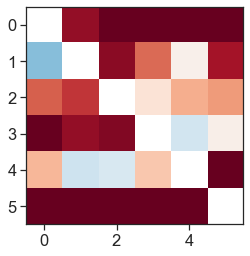

In [17]:
plt.imshow(all_perf/all_perf_ctr,vmin=0,vmax=1,cmap='RdBu_r')
plt.xlim(-.5,5.5)
plt.ylim(5.5,-.5)


In [212]:
all_state_seq = get_base_info(lines)

In [171]:
variables = eval(re.findall('Variables({.*})',lines[-1])[0])
state_dict = eval(lines[5][2:-1])
event_dict = eval(lines[7][2:-1])
event_dict2 = {v: k for k, v in event_dict.items()}


In [172]:
light_on_ts = get_lights_on_timers(lines)

In [173]:
inPokes, inPoke_ts = get_inpoke_data(lines)
rew_ts = get_rew_timers(lines) - float(variables['rew_dur'])
sequence = eval(variables['fixed_seq'])

In [174]:
sequence = eval(variables['fixed_seq'])

In [180]:
state_pokes = []
for lt in light_on_ts[1:]:
    tmp = inPoke_ts[inPoke_ts>(lt-250)]
    ltmp = len(tmp)
    stp = np.argmin(np.abs(tmp - (lt-200))) + (len(inPoke_ts) - len(tmp))
    state_pokes.append(stp)
    #print(np.min(np.abs(inPoke_ts[inPoke_ts>(lt-250)] - (lt-200))))

for rt in rew_ts:
    stp = len(inPoke_ts[inPoke_ts<(rt)])-1
    #print(inPoke_ts[inPoke_ts<rt][-1] - rt)
    state_pokes.append(stp)
    #stp = np.argmin()
state_poke = np.array(sorted(state_pokes))

In [181]:
sequence

[5, 4, 6, 8, 2, 0]

In [182]:
state_pokes = []
for lt in light_on_ts[1:]:
    tmp = inPoke_ts[inPoke_ts>(lt-250)]
    ltmp = len(tmp)
    stp = np.argmin(np.abs(tmp - (lt-200))) + (len(inPoke_ts) - len(tmp))
    state_pokes.append(stp)
    #print(np.min(np.abs(inPoke_ts[inPoke_ts>(lt-250)] - (lt-200))))

for rt in rew_ts:
    stp = len(inPoke_ts[inPoke_ts<(rt)])-1
    #print(inPoke_ts[inPoke_ts<rt][-1] - rt)
    state_pokes.append(stp)
    #stp = np.argmin()
state_poke = np.array(sorted(state_pokes))


state_seq = np.array([sequence.index(inPokes[i]-1) for i in state_poke])
inPoke_ts = inPoke_ts[state_poke]

all_state_seq = []
for r1, r2 in zip(rew_ts[:-1],rew_ts[1:]):
    tmp = state_seq[np.logical_and(inPoke_ts>r1,inPoke_ts<(r2+100))]

    
    
    all_state_seq.append(tmp)

In [178]:
all_state_seq = []
for r1, r2 in zip(rew_ts[:-1],rew_ts[1:]):
    tmp = state_seq[np.logical_and(inPoke_ts>r1,inPoke_ts<(r2+100))]
    all_state_seq.append(tmp)

In [179]:
all_state_seq

[array([0, 1]),
 array([3, 2, 1]),
 array([0, 1]),
 array([5, 4, 5, 4, 3, 2, 1]),
 array([4, 3, 2, 1]),
 array([3, 2, 1]),
 array([3, 2, 1]),
 array([5, 4, 3, 2, 1]),
 array([5, 4, 3, 2, 1]),
 array([3, 2, 1]),
 array([3, 2, 1]),
 array([4, 5, 4, 3, 2, 1]),
 array([5, 4, 3, 2, 1]),
 array([5, 4, 5, 4, 5, 4, 3, 2, 1]),
 array([2, 1]),
 array([0, 1]),
 array([0, 1]),
 array([5, 4, 5, 4, 5, 4, 5, 0, 1]),
 array([5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 3, 2, 1]),
 array([4, 3, 2, 1]),
 array([5, 4, 3]),
 array([5, 4, 3]),
 array([0, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 3])]

In [ ]:
res_dict = {}
mus = []
for ix in range(np.clip(len(fs)-20,0,1000),len(fs)):
    if 'seq' in fs[ix]:
        if ('170221_round5_1' in fs_dir) and ('timeout' in fs[ix] or 'seq2' not in fs[ix]):
            pass
        else:
            try:
                res_dict__ = {}
                f = open(os.path.join(fs_dir,fs[ix]),'r')

                lines = f.readlines()
                variables = eval(re.findall('Variables({.*})',lines[-1])[0])
                res_dict = evaluate_probe_trials(lines,res_dict=res_dict)
                res_dict__ = evaluate_probe_trials(lines)
                mus.append(np.nanmean([np.nanmean(i) for i in res_dict__.values()]))
                pints =[np.nanmean([np.nanmean(i) for i in res_dict__.values()]),
                     np.sum([len(i) for i in res_dict__.values()]),
                     float(variables['n_rewards']),
                     fs[ix]]
                print('probe_perf={:.2f}   | nProbe={:.0f}   | nRews={:.0f}  |  file={}'.format(*pints))
            except:
                print('WARNING FILE {} failed to be processed'.format(fs[ix]))
#print(fs[ix])

In [ ]:
stt.binom_test(66,278,0.25)

In [133]:
import scipy.stats as stt

In [134]:

stt.binom_test(6,7)

0.125